# Profiling skforecast

This document shows the profiling of the main classes, methods and functions available in skforecast. Understanding the bottlenecks will help to:

+ Use it more efficiently
+ Improve the code for future releases

## Libraries

In [1]:
# Libraries
# ==============================================================================
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from lightgbm import LGBMRegressor

%load_ext pyinstrument

## Data

A time series of length 1000 with random values is created.

In [2]:
# Data
# ==============================================================================
np.random.seed(123)
n = 1_000
data = pd.Series(data = np.random.normal(size=n))

## Dummy regressor

To isolate the training process of the regressor from the other parts of the code, a dummy regressor class is created. This dummy regressor has a fit method that does nothing, and a predict method that returns a constant value.

In [3]:
class DummyRegressor(LinearRegression):
    """
    Dummy regressor with dummy fit and predict methods.
    """
    
    def fit(self, X, y):
        pass

    def predict(self, y):
        predictions = np.ones(shape = len(y))
        return predictions
        

## Profiling fit

In [4]:
%%pyinstrument

forecaster = ForecasterAutoreg(
                 regressor = DummyRegressor(),
                 lags      = 24
             )

forecaster.fit(y=data)

_     ._   __/__   _ _  _  _ _/_   Recorded: 20:51:26  Samples:  2
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.003     CPU time: 0.000
/   _/                      v4.4.0

Program: c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\ipykernel_launcher.py --ip=127.0.0.1 --stdin=9013 --control=9011 --hb=9010 --Session.signature_scheme="hmac-sha256" --Session.key=b"a63f9796-5710-4436-a214-ef085e7d16b0" --shell=9012 --transport="tcp" --iopub=9014 --f=c:\Users\jaesc2\AppData\Roaming\jupyter\runtime\kernel-v2-15684k1LSZTeeU4nj.json

0.002 <module>  ..\..\..\AppData\Local\Temp\ipykernel_29056\2958573061.py:2
`- 0.002 ForecasterAutoreg.fit  skforecast\ForecasterAutoreg\ForecasterAutoreg.py:463
      [22 frames hidden]  skforecast, pandas, warnings, re, sre...

Almost all of the time spent by `fit` is required by the `create_train_X_y` method.

In [5]:
%%pyinstrument

forecaster = ForecasterAutoreg(
                 regressor = HistGradientBoostingRegressor(max_iter=10, random_state=123),
                 lags      = 24
             )

forecaster.fit(y=data)

_     ._   __/__   _ _  _  _ _/_   Recorded: 20:51:26  Samples:  121
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.137     CPU time: 1.016
/   _/                      v4.4.0

Program: c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\ipykernel_launcher.py --ip=127.0.0.1 --stdin=9013 --control=9011 --hb=9010 --Session.signature_scheme="hmac-sha256" --Session.key=b"a63f9796-5710-4436-a214-ef085e7d16b0" --shell=9012 --transport="tcp" --iopub=9014 --f=c:\Users\jaesc2\AppData\Roaming\jupyter\runtime\kernel-v2-15684k1LSZTeeU4nj.json

0.137 <module>  ..\..\..\AppData\Local\Temp\ipykernel_29056\1359942394.py:2
`- 0.137 ForecasterAutoreg.fit  skforecast\ForecasterAutoreg\ForecasterAutoreg.py:463
      [163 frames hidden]  skforecast, sklearn, <built-in>, nump...

When training a forecaster with a real machine learning regressor, the time spent by `create_train_X_y` is negligible compared to the time needed by the `fit` method of the regressor. Therefore, improving the speed of `create_train_X_y` will not have much impact.

## Profiling create_train_X_y

Understand how the `create_train_X_y` method is influenced by the length of the series and the number of lags. 

In [6]:
# Profiling `create_train_X_y` for different length of series and number of lags
# ======================================================================================
series_length = np.linspace(1000, 1000000, num=5, dtype=int)
n_lags = [5, 10, 50, 100, 200]
results = {}

for lags in n_lags:
    execution_time = []
    forecaster = ForecasterAutoreg(
                     regressor = DummyRegressor(),
                     lags      = lags
                 )

    for n in series_length:
        y = pd.Series(data = np.random.normal(size=n))
        tic = time.perf_counter()
        _ = forecaster.create_train_X_y(y=y)
        toc = time.perf_counter()
        execution_time.append(toc-tic)

    results[lags] = execution_time

results = pd.DataFrame(
              data =  results,
              index = series_length
          )

results

,5,10,50,100,200
1000,0.000916,0.005203,0.007820,0.030376,0.084018
250750,0.005732,0.012114,0.148144,0.307737,0.791776
500500,0.034383,0.081557,0.446560,0.656159,1.644211
750250,0.036675,0.097606,0.476057,1.550512,2.392158
1000000,0.035490,0.084168,0.698921,2.177158,2.622958


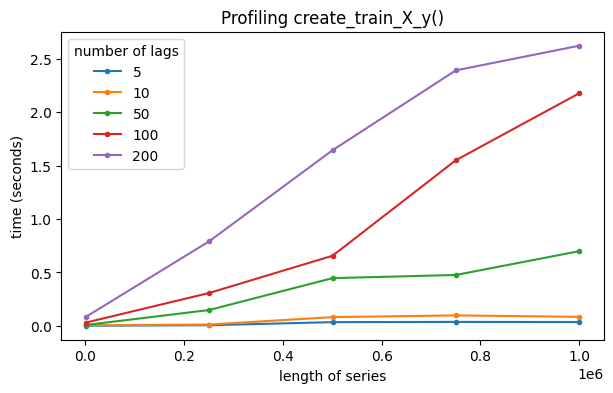

In [7]:
fig, ax = plt.subplots(figsize=(7, 4))
results.plot(ax=ax, marker='.')
ax.set_xlabel('length of series')
ax.set_ylabel('time (seconds)')
ax.set_title('Profiling create_train_X_y()')
ax.legend(title='number of lags');

## Profiling predict

In [8]:
forecaster = ForecasterAutoreg(
                 regressor = DummyRegressor(),
                 lags      = 24
             )

forecaster.fit(y=data)

In [9]:
%%pyinstrument

_ = forecaster.predict(steps=1000)

_     ._   __/__   _ _  _  _ _/_   Recorded: 20:51:41  Samples:  17
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.156     CPU time: 0.172
/   _/                      v4.4.0

Program: c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\ipykernel_launcher.py --ip=127.0.0.1 --stdin=9013 --control=9011 --hb=9010 --Session.signature_scheme="hmac-sha256" --Session.key=b"a63f9796-5710-4436-a214-ef085e7d16b0" --shell=9012 --transport="tcp" --iopub=9014 --f=c:\Users\jaesc2\AppData\Roaming\jupyter\runtime\kernel-v2-15684k1LSZTeeU4nj.json

0.156 <module>  ..\..\..\AppData\Local\Temp\ipykernel_29056\3639615597.py:2
|- 0.140 [self]  None
`- 0.016 ForecasterAutoreg.predict  skforecast\ForecasterAutoreg\ForecasterAutoreg.py:594
      [21 frames hidden]  skforecast, <__array_function__ inter...
         0.016 ForecasterAutoreg._recursive_predict  skforecast\ForecasterAutoreg\ForecasterAutoreg.py:545
         |- 0.004 DummyRegressor.predict  ..\..\..\AppData\Local\Temp\ipykernel_29056\3778797810.py:9
         |  `- 0.004 ones  numpy\core\numeric.py:149
         |        [7 frames hidden]  numpy, <__array_function__ internals>...

In [10]:
forecaster = ForecasterAutoreg(
                 regressor = HistGradientBoostingRegressor(max_iter=10, random_state=123),
                 lags      = 24
             )

forecaster.fit(y=data)

In [11]:
%%pyinstrument

_ = forecaster.predict(steps=1000)

_     ._   __/__   _ _  _  _ _/_   Recorded: 20:51:42  Samples:  373
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.376     CPU time: 5.516
/   _/                      v4.4.0

Program: c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\ipykernel_launcher.py --ip=127.0.0.1 --stdin=9013 --control=9011 --hb=9010 --Session.signature_scheme="hmac-sha256" --Session.key=b"a63f9796-5710-4436-a214-ef085e7d16b0" --shell=9012 --transport="tcp" --iopub=9014 --f=c:\Users\jaesc2\AppData\Roaming\jupyter\runtime\kernel-v2-15684k1LSZTeeU4nj.json

0.376 <module>  ..\..\..\AppData\Local\Temp\ipykernel_29056\3639615597.py:2
`- 0.376 ForecasterAutoreg.predict  skforecast\ForecasterAutoreg\ForecasterAutoreg.py:594
      [157 frames hidden]  skforecast, sklearn, <built-in>, <__a...

Inside the `predict` method, the `append` action is the most expensive but, similar to what happen with `fit`, it is negligible compared to the time need by the `predict` method of the regressor.

In [12]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>